In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [2]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *
from config import *

In [3]:
config = Config()

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5')

# Fig 4 - Cell state distributions per fate

#### Get cell state labels for each window

In [5]:
cell_labels = pd.read_csv(config.CELL_LABELS, header=0)
display(cell_labels.index)

RangeIndex(start=0, stop=28494, step=1)

In [6]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [7]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])

#### Always use pseudotime to bin windows instead of window indices - as pseudotime is the temporal spread/distribution and not the indices

In [8]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [9]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [14]:
pseudotime_values_of_windows = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2]).pseudotime_of_windows()

Time points per bin: [15, 17, 3, 3, 4, 3, 5, 1]
Total cells per bin: [np.float64(999.8), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0)]


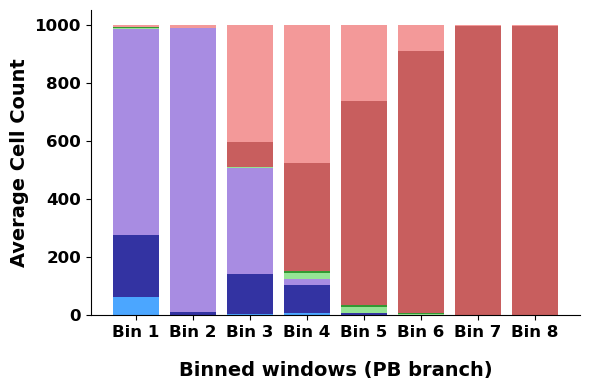

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[PB_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
#plt.savefig(os.path.join(output_folder, 'fig4_state_count_PB_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Pseudotime curves of TF expression and activity

In [41]:
exp_curves_dy, exp_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="expression")

In [42]:
reg_curves_dy, reg_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="regulation")

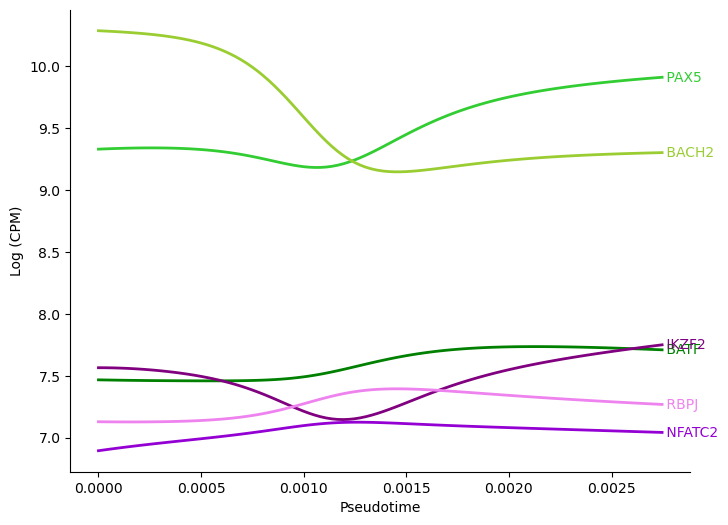

In [55]:
# Plot expression trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in exp_curves_dy.index:
        line = plt.plot(exp_curves_dx, exp_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(exp_curves_dx.iloc[-1], exp_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (CPM)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_exp.pdf'), dpi=300)
plt.show()

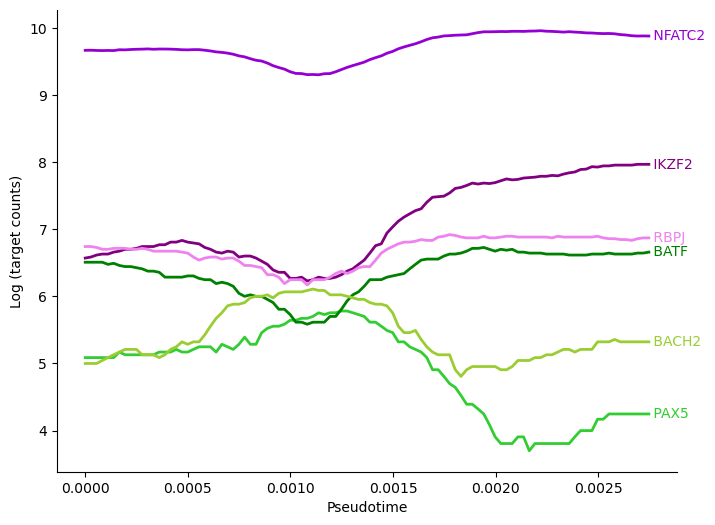

In [56]:
# Plot regulation trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in reg_curves_dy.index:
        line = plt.plot(reg_curves_dx, reg_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(reg_curves_dx.iloc[-1], reg_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (target counts)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_reg.pdf'), dpi=300)
plt.show()

# Enriched links

In [25]:
PB_links_plotting = [('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('BACH2','XBP1'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [33]:

GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]


#### Initialize pseudotime object

In [34]:
pseudotime_object = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01)

In [35]:
beta_curves, dtime = pseudotime_object.get_beta_curves(GC_links_plotting, varname='w_in')

In [36]:
# get the expression curves of the TFs in the specified links
tf_expression, _ = pseudotime_object.get_smoothed_curves(mode='tf_expression')
regulon_tf_expression = tf_expression.loc[beta_curves.index.get_level_values(0).unique()]

In [37]:
force_curves = pseudotime_object.calculate_force_curves(beta_curves, regulon_tf_expression)

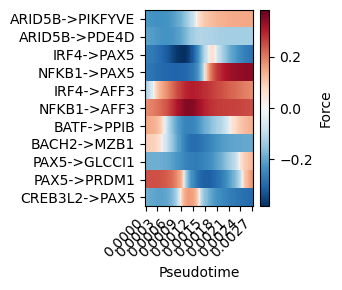

In [ ]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this link to x% of its original values
}

df_plot = force_curves.loc[GC_links_plotting]

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=df_plot,
    dtime=dtime,
    regulations=GC_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (3.5, 3),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=row_scaling
)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'enriched_links_GC.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            format='pdf')
plt.show()

# Fig 5/6 - Episodic enrichment plots
### Direct effect enrichment 

In [19]:
df_ep1 = pd.read_csv(config.ETS1_ALL['ep1'])
df_ep2 = pd.read_csv(config.ETS1_ALL['ep2'])
df_ep3 = pd.read_csv(config.ETS1_ALL['ep3'])
df_ep4 = pd.read_csv(config.ETS1_ALL['ep4'])
df_ep5 = pd.read_csv(config.ETS1_ALL['ep5'])
df_ep6 = pd.read_csv(config.ETS1_ALL['ep6'])

In [20]:
def plot_tf_episodic_enrichment_dotplot(
    dfs,
    episode_labels,
    figsize=(12, 8),
    min_dot_size=10,
    max_dot_size=300,
    p_value_threshold=0.05,
    min_significance_threshold=None,
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="coolwarm",
    value_legend_title="ES",
    size_legend_title="P-val",
    sort_by_gene_similarity=False,
    show_dendrogram=False,
    dendrogram_ratio=0.2,
    figure_title=None,
    log_scale=False,
    show_plot=True,
    tf_order=None,
    horizontal_layout=False  # NEW PARAMETER
):
    """
    Plots a dotplot for TF episodic enrichment.
    
    Parameters:
    -----------
    horizontal_layout : bool, default False
        If True, episodes are on y-axis (top to bottom) and TFs on x-axis (left to right).
        If False (default), TFs are on y-axis and episodes on x-axis.
    """    
    # 1-5. [Same validation and filtering code as before]
    required_cols = ['TF', 'p_value', 'enrichment_score', 'genes_in_lf', 'genes_dwnstrm']
    
    for i, df in enumerate(dfs):
        if df is None or df.empty:
            print(f"Episode {i+1} dataframe is None or empty.")
            return None, None, None
        for col in required_cols:
            if col not in df.columns:
                print(f"Episode {i+1} dataframe missing required column: {col}")
                return None, None, None
    
    def parse_genes_in_lf(genes_str):
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            genes_tuple = ast.literal_eval(genes_str)
            if isinstance(genes_tuple, tuple):
                return set(genes_tuple)
            elif isinstance(genes_tuple, str):
                return {genes_tuple}
            else:
                return set()
        except:
            return set()
                
    tf_genes_dict = {}
    tf_dwnstrm_genes_dict = {}
    plot_data_list = []
    
    for i, (df, episode_label) in enumerate(zip(dfs, episode_labels)):
        df_clean = df.dropna(subset=['TF', 'p_value', 'enrichment_score'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_in_lf_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            genes_dwnstrm_set = parse_genes_in_lf(row.get('genes_dwnstrm', ''))
            
            if tf_name not in tf_genes_dict:
                tf_genes_dict[tf_name] = set()
                tf_dwnstrm_genes_dict[tf_name] = set()
            tf_genes_dict[tf_name].update(genes_in_lf_set)
            tf_dwnstrm_genes_dict[tf_name].update(genes_dwnstrm_set)
            
            plot_data_list.append({
                'episode': episode_label,
                'episode_idx': i,
                'TF': tf_name,
                'p_value': row['p_value'],
                'enrichment_score': row['enrichment_score']
            })
    
    if not plot_data_list:
        print("No valid data found across all episodes.")
        return None, None, None
    
    plot_data_df = pd.DataFrame(plot_data_list)
    
    valid_tfs = set()
    for tf_name in tf_genes_dict.keys():
        lf_gene_count = len(tf_genes_dict[tf_name])
        dwnstrm_gene_count = len(tf_dwnstrm_genes_dict[tf_name])
        
        if lf_gene_count >= min_targets_in_lf and dwnstrm_gene_count >= min_targets_dwnstrm:
            valid_tfs.add(tf_name)
    
    if not valid_tfs:
        print(f"No TFs meet the criteria: >= {min_targets_in_lf} LF genes AND >= {min_targets_dwnstrm} downstream genes")
        return None, None, None
    
    plot_data_df = plot_data_df[plot_data_df['TF'].isin(valid_tfs)]
    tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in valid_tfs}
    tf_dwnstrm_genes_dict = {tf: genes for tf, genes in tf_dwnstrm_genes_dict.items() if tf in valid_tfs}
    
    print(f"Filtered to {len(valid_tfs)} TFs that meet gene count criteria")
    
    if min_significance_threshold is not None:
        significant_tfs = set()
        tf_min_pvalues = plot_data_df.groupby('TF')['p_value'].min()
        significant_tfs = set(tf_min_pvalues[tf_min_pvalues < min_significance_threshold].index)
        
        if not significant_tfs:
            print(f"No TFs meet the minimum significance threshold of {min_significance_threshold}")
            return None, None, None

        plot_data_df = plot_data_df[plot_data_df['TF'].isin(significant_tfs)]
        tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in significant_tfs}
        
        print(f"Further filtered to {len(significant_tfs)} TFs that meet significance threshold < {min_significance_threshold}")

    # 6. Sort TFs
    if tf_order is not None:
        available_tfs = set(tf_genes_dict.keys())
        all_tfs_sorted = [tf for tf in tf_order if tf in available_tfs]
        remaining_tfs = sorted(available_tfs - set(all_tfs_sorted))
        all_tfs_sorted.extend(remaining_tfs)
        linkage_matrix = None
        original_tf_labels = None
        if remaining_tfs:
            print(f"Note: {len(remaining_tfs)} TFs not in custom order were added alphabetically")
    elif sort_by_gene_similarity:
        if show_dendrogram:
            all_tfs_sorted, linkage_matrix, original_tf_labels = sort_tfs_by_gene_similarity(
                tf_genes_dict, return_linkage=True)
        else:
            all_tfs_sorted = sort_tfs_by_gene_similarity(tf_genes_dict)
            linkage_matrix = None
            original_tf_labels = None
    else:
        all_tfs_sorted = sorted(tf_genes_dict.keys())
        linkage_matrix = None
        original_tf_labels = None
    
    # 7. Map p-values to dot sizes
    def p_value_to_size(p_val):
        if p_val > p_value_threshold:
            return min_dot_size * 0.5
        min_p_cap = 1e-6
        log_p = -np.log10(max(p_val, min_p_cap))
        log_thresh = -np.log10(p_value_threshold)
        log_min_cap = -np.log10(min_p_cap)
        
        if log_min_cap == log_thresh:
            scaled_val = 1.0
        else:
            scaled_val = (log_p - log_thresh) / (log_min_cap - log_thresh)
        
        size = min_dot_size + (max_dot_size - min_dot_size) * min(scaled_val, 1.0)
        return size

    plot_data_df['dot_size'] = plot_data_df['p_value'].apply(p_value_to_size)

    if log_scale:
        min_enrichment = plot_data_df['enrichment_score'].min()
        if min_enrichment <= 0:
            offset = abs(min_enrichment) + 1e-6
            plot_data_df['enrichment_score_log'] = np.log2(plot_data_df['enrichment_score'] + offset)
            value_legend_title = f"log2({value_legend_title} + {offset:.1e})"
        else:
            plot_data_df['enrichment_score_log'] = np.log2(plot_data_df['enrichment_score'])
            value_legend_title = f"log2({value_legend_title})"
        color_values = plot_data_df['enrichment_score_log']
    else:
        color_values = plot_data_df['enrichment_score']

    # 8. Create coordinate mappings - MODIFIED FOR HORIZONTAL LAYOUT
    if horizontal_layout:
        # TFs on x-axis, Episodes on y-axis
        tf_x_coords = {tf: i for i, tf in enumerate(all_tfs_sorted)}
        episode_y_coords = {label: i for i, label in enumerate(episode_labels)}
    else:
        # Original: Episodes on x-axis, TFs on y-axis
        episode_x_coords = {label: i for i, label in enumerate(episode_labels)}
        tf_y_coords = {tf: i for i, tf in enumerate(all_tfs_sorted)}
    
    # 9. Create figure with subplots
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        fig = plt.figure(figsize=figsize)
        
        if horizontal_layout:
            # Dendrogram above the plot
            dendro_height = dendrogram_ratio
            main_height = 1 - dendro_height - 0.15
            
            ax_dendro = fig.add_subplot(2, 1, 1)
            ax_main = fig.add_subplot(2, 1, 2)
            
            dendro_bottom = 0.7
            main_bottom = 0.1
            
            ax_dendro.set_position([0.1, dendro_bottom, 0.7, dendro_height])
            ax_main.set_position([0.1, main_bottom, 0.7, main_height])

            dendro_plot = dendrogram(
                linkage_matrix, 
                ax=ax_dendro,
                orientation='top',
                labels=original_tf_labels,
                leaf_font_size=8,
                color_threshold=0.7*max(linkage_matrix[:,2])
            )
            ax_dendro.set_xlabel("TF Clustering")
            ax_dendro.set_ylabel("Distance")
            ax_dendro.spines['top'].set_visible(False)
            ax_dendro.spines['right'].set_visible(False)
            ax_dendro.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        else:
            # Dendrogram to the left (original)
            dendro_width = dendrogram_ratio
            main_width = 1 - dendro_width - 0.15
            
            ax_dendro = fig.add_subplot(1, 2, 1)
            ax_main = fig.add_subplot(1, 2, 2)
            
            dendro_left = 0.05
            main_left = dendro_left + dendro_width + 0.02
            
            ax_dendro.set_position([dendro_left, 0.1, dendro_width, 0.8])
            ax_main.set_position([main_left, 0.1, main_width, 0.8])

            dendro_plot = dendrogram(
                linkage_matrix, 
                ax=ax_dendro,
                orientation='left',
                labels=original_tf_labels,
                leaf_font_size=8,
                color_threshold=0.7*max(linkage_matrix[:,2])
            )
            ax_dendro.invert_yaxis()
            ax_dendro.set_ylabel("TF Clustering")
            ax_dendro.set_xlabel("Distance")
            ax_dendro.spines['top'].set_visible(False)
            ax_dendro.spines['right'].set_visible(False)
            ax_dendro.tick_params(axis='y', which='both', left=False, labelleft=False)
    else:
        fig, ax_main = plt.subplots(figsize=figsize)
    
    # 10. Create scatter plot - MODIFIED FOR HORIZONTAL LAYOUT
    if horizontal_layout:
        scatter = ax_main.scatter(
            x=plot_data_df['TF'].map(tf_x_coords),
            y=plot_data_df['episode'].map(episode_y_coords),
            s=plot_data_df['dot_size'],
            c=color_values,
            cmap=cmap_name,
            edgecolors='gray',
            linewidths=0.5,
            alpha=0.8
        )
    else:
        scatter = ax_main.scatter(
            x=plot_data_df['episode'].map(episode_x_coords),
            y=plot_data_df['TF'].map(tf_y_coords),
            s=plot_data_df['dot_size'],
            c=color_values,
            cmap=cmap_name,
            edgecolors='gray',
            linewidths=0.5,
            alpha=0.8
        )
    
    # 11. Axis formatting - MODIFIED FOR HORIZONTAL LAYOUT
    if horizontal_layout:
        # X-axis: TFs (left to right)
        ax_main.set_xticks(list(tf_x_coords.values()))
        ax_main.set_xticklabels(all_tfs_sorted, rotation=90, ha="center")
        x_pad = 0.5
        ax_main.set_xlim(-x_pad, len(all_tfs_sorted) - 1 + x_pad)
        ax_main.set_xlabel("TFs", fontsize=12, fontweight='bold')
        
        # Y-axis: Episodes (top to bottom)
        ax_main.set_yticks(list(episode_y_coords.values()))
        ax_main.set_yticklabels(episode_labels, rotation=0, ha="right")
        y_pad = 0.5
        ax_main.set_ylim(-y_pad, len(episode_labels) - 1 + y_pad)
        ax_main.set_ylabel("Episodes", fontsize=12, fontweight='bold', labelpad=15)
    else:
        # X-axis: Episodes
        ax_main.set_xticks(list(episode_x_coords.values()))
        ax_main.set_xticklabels(episode_labels, rotation=0, ha="center")
        x_pad = 0.5
        ax_main.set_xlim(-x_pad, len(episode_labels) - 1 + x_pad)
        ax_main.set_xlabel("Episodes", fontsize=12, fontweight='bold', labelpad=15)
        
        # Y-axis: TFs
        ax_main.set_yticks(list(tf_y_coords.values()))
        ax_main.set_yticklabels(all_tfs_sorted)
        ax_main.set_ylabel("TFs", fontsize=12, fontweight='bold')
    
    # 12. Size legend for P-values
    legend_p_values = [0.001, 0.01]
    legend_dots = []
    
    for p_val in legend_p_values:
        size_val = p_value_to_size(p_val)
        if p_val > p_value_threshold:
            label_text = f"{p_value_threshold}"
        else:
            label_text = f"{p_val}"
        legend_dots.append(plt.scatter([], [], s=size_val, c='gray', label=label_text))
    
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        if horizontal_layout:
            bbox_anchor = (1.15, 0.5)
        else:
            bbox_anchor = (1.25, 0.6)
    else:
        bbox_anchor = (1.18, 0.6)
        
    size_leg = ax_main.legend(
        handles=legend_dots, 
        title=size_legend_title,
        bbox_to_anchor=bbox_anchor, 
        loc='center left',
        labelspacing=1.5, 
        borderpad=1, 
        frameon=True,
        handletextpad=1.5,
        scatterpoints=1
    )
    
    # 13. Colorbar
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        if horizontal_layout:
            cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
        else:
            cbar_ax = fig.add_axes([0.85, 0.15, 0.3, 0.03])
    else:
        cbar_ax = fig.add_axes([0.65, 0.4, 0.2, 0.02])
    
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(value_legend_title, fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # 14. Final formatting
    ax_main.grid(True, linestyle='--', alpha=0.3, axis='both')
    ax_main.tick_params(axis='both', which='major', pad=5)
    
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=14, fontweight='bold', y=0.95)

    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, plot_data_df, all_tfs_sorted

Filtered to 69 TFs that meet gene count criteria
Further filtered to 9 TFs that meet significance threshold < 0.004


/tmp/ipykernel_9872/1097008227.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


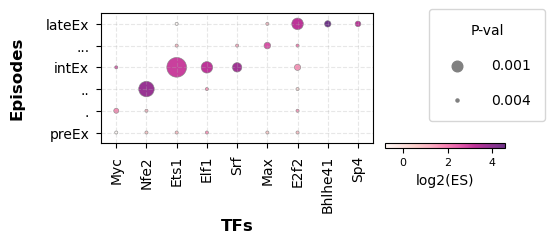

In [34]:
# Define your desired TF order

# custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
# custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
# custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
# custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4, df_ep5, df_ep6],
    episode_labels=['preEx', '.', '..', 'intEx', '...', 'lateEx'],
    figsize=(6, 2.5), #breadth by length
    p_value_threshold=0.004,
    min_significance_threshold=0.004, 
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="RdPu",
    tf_order=custom_tf_order_ets1_all,
    figure_title=None,
    log_scale=True,
    horizontal_layout=True
)
# save the plot
fig.savefig(os.path.join(config.OUTPUT_FOLDER, "ets1_all_horizontal.pdf"), dpi=300)

# Ext. Fig - Chromatin level TF activity over pseudotime